In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, log_loss, confusion_matrix, roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

import xgboost

In [2]:
df = pd.read_csv('dataset.csv')
df

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


### EDA | Цель: пощупать, посмотреть, проверить на выбросы, пропуски, построить графики и какие трансформации нужны

In [3]:
df.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

### Смотрим на mean,std и перцентали т.д

In [4]:
df.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


Разделяю фичи на категориальные и числовые

In [5]:
categorical_features = ['gender', 'department', 'recruitment_channel','region', 'length_of_service', 'education', 'no_of_trainings', 'previous_year_rating', 'awards_won?', 'KPIs_met >80%']
numeric_features = ['age','avg_training_score']
target_column = ['is_promoted']

#### Пропущенные значения в датасете, какой процент к каждому столбцу

In [6]:
total_missing = df.isnull().sum().sum()

missing_per_column = df.isnull().sum()

percent_missing_per_column = (missing_per_column / total_missing) * 100

print(percent_missing_per_column)

employee_id              0.00000
department               0.00000
region                   0.00000
education               36.87433
gender                   0.00000
recruitment_channel      0.00000
no_of_trainings          0.00000
age                      0.00000
previous_year_rating    63.12567
length_of_service        0.00000
KPIs_met >80%            0.00000
awards_won?              0.00000
avg_training_score       0.00000
is_promoted              0.00000
dtype: float64


### Агаааа, столбец previous_year_rating имеет большинство пропусков, давайте посмотрим сколько и что будем делать

In [7]:
df[df['previous_year_rating'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 4124 entries, 10 to 54801
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           4124 non-null   int64  
 1   department            4124 non-null   object 
 2   region                4124 non-null   object 
 3   education             3739 non-null   object 
 4   gender                4124 non-null   object 
 5   recruitment_channel   4124 non-null   object 
 6   no_of_trainings       4124 non-null   int64  
 7   age                   4124 non-null   int64  
 8   previous_year_rating  0 non-null      float64
 9   length_of_service     4124 non-null   int64  
 10  KPIs_met >80%         4124 non-null   int64  
 11  awards_won?           4124 non-null   int64  
 12  avg_training_score    4124 non-null   int64  
 13  is_promoted           4124 non-null   int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 483.3+ KB


#### 4 тысячи, не так много, но что-то мне подсказывает что это значение очень коррелируют с таргетом, поэтому УДАЛИМ

In [8]:
df = df.dropna(subset=['previous_year_rating'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50684 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           50684 non-null  int64  
 1   department            50684 non-null  object 
 2   region                50684 non-null  object 
 3   education             48660 non-null  object 
 4   gender                50684 non-null  object 
 5   recruitment_channel   50684 non-null  object 
 6   no_of_trainings       50684 non-null  int64  
 7   age                   50684 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     50684 non-null  int64  
 10  KPIs_met >80%         50684 non-null  int64  
 11  awards_won?           50684 non-null  int64  
 12  avg_training_score    50684 non-null  int64  
 13  is_promoted           50684 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.8+ MB


#### Безжалостно удалили previous_year_rating, теперь с education, просто заполним наиболее встречающим, а это Bachelor

In [9]:
df['education'].value_counts()

education
Bachelor's          33404
Master's & above    14798
Below Secondary       458
Name: count, dtype: int64

In [10]:
df.loc[:, 'education'] = df['education'].fillna("Bachelor's")

In [11]:
df['education'].value_counts()

education
Bachelor's          35428
Master's & above    14798
Below Secondary       458
Name: count, dtype: int64

## C пропусками покончили, теперь проверяем выбросы и в целом на распределение данныx

<Axes: >

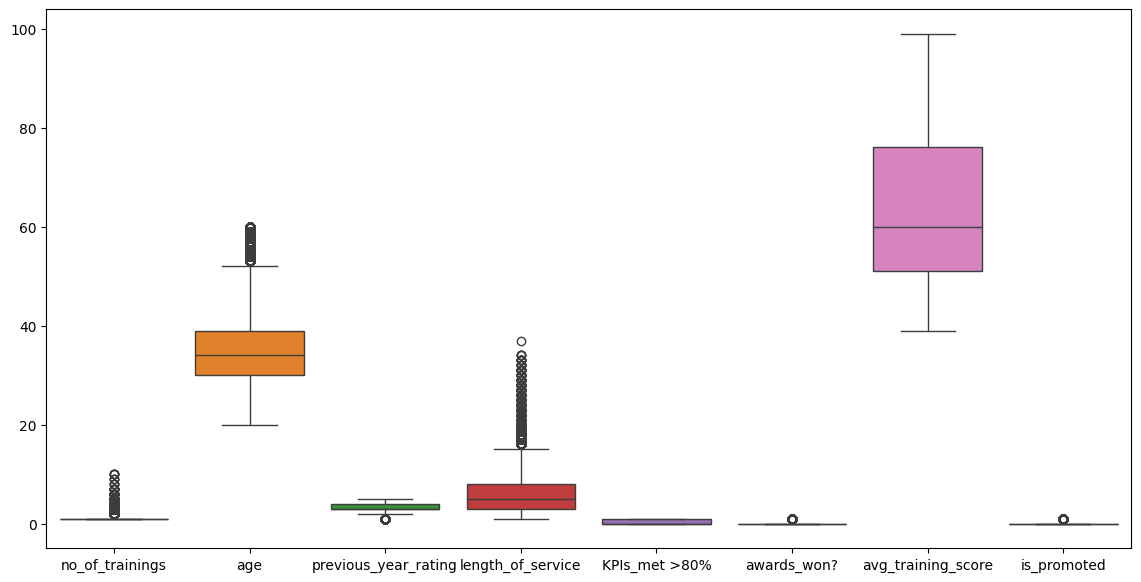

In [12]:
fig, ax = plt.subplots(figsize=(14, 7))


sns.boxplot(data=df.iloc[:, 1:])


In [13]:
df['previous_year_rating'].value_counts()


previous_year_rating
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: count, dtype: int64

### Какие возврасты более 'подвержены' повышению ))

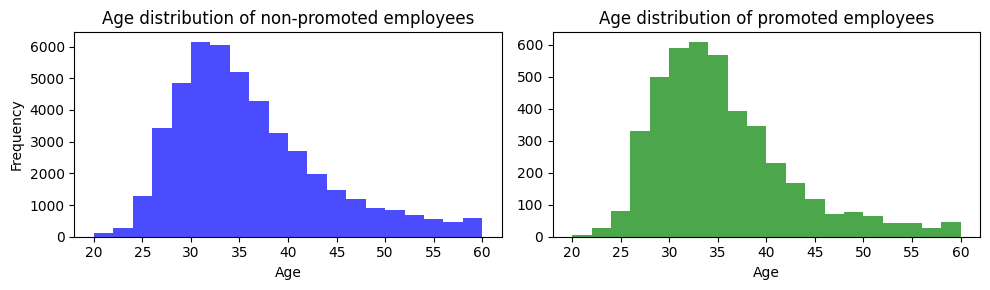

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].hist(df[df['is_promoted'] == 0]['age'], bins=20, color='blue', alpha=0.7)
ax[0].set_title('Age distribution of non-promoted employees')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')


ax[1].hist(df[df['is_promoted'] == 1]['age'], bins=20, color='green', alpha=0.7)
ax[1].set_title('Age distribution of promoted employees')
ax[1].set_xlabel('Age')

plt.tight_layout()
plt.show()

### Визуализации матрицы корреляции и смотря на нее можно посмотреть какие фичи коррелируют с таргетом, а у каких фичей есть мультиколлинеарность

<Axes: >

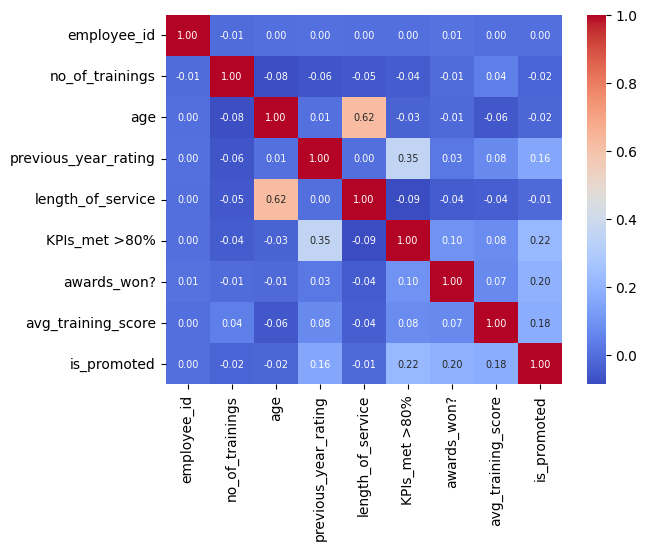

In [15]:
corr_matrix = df[df.select_dtypes(include=['float64', 'int64']).columns.tolist()].corr()

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, annot_kws={"fontsize": 7}, fmt='.2f', square=False)

### Видим что KPIs_met коррелирует с prev и length_of_service с age, ну предлагаю удалить age, ну и видим что KPI коррелирует более менее с таргетом(что логично), заодно и начинаем one_hot_encoding

In [16]:
df = df.drop('age', axis = 1)

In [17]:
df_dummies = pd.get_dummies(df, columns=categorical_features)
df_dummies = df_dummies.astype(int)
df_dummies.head()

,employee_id,avg_training_score,is_promoted,gender_f,gender_m,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,...,no_of_trainings_10,previous_year_rating_1.0,previous_year_rating_2.0,previous_year_rating_3.0,previous_year_rating_4.0,previous_year_rating_5.0,awards_won?_0,awards_won?_1,KPIs_met >80%_0,KPIs_met >80%_1
0,65438,49,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1
1,65141,60,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,1,0,1,0
2,7513,50,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,2542,50,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,48945,73,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0


In [18]:
df_dummies['is_promoted'].value_counts()

is_promoted
0    46355
1     4329
Name: count, dtype: int64

### Видим дикий дисбаланс классов, будем использовать recall, precision и roc-auc

In [19]:
pd.set_option('display.max_columns', 100)

# Установка максимальной ширины строки для отображения
pd.set_option('display.width', 100)

In [20]:
X = df_dummies.drop(['is_promoted','employee_id'], axis=1)
y = df_dummies['is_promoted']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
loss_folds = []
roc_scores = []
precision_scores =[]
recall_scores = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

params = {
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'gamma': 7,
    'max_depth': 10,
    'lambda': 0.5,
    'alpha': 0.8,
    'n_estimators': 2000,
    'eval_metric': 'logloss',
    'early_stopping_rounds': 50,
    'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1)
}

model = xgboost.XGBClassifier(**params)

for idx_train, idx_valid in kf.split(X_train, y_train):
    X_train_k, y_train_k = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
    
    model.fit(X_train_k, y_train_k, eval_set=[(X_valid, y_valid)], verbose=False)
    
    y_pred_val = model.predict(X_valid)
    y_pred_proba_val = model.predict_proba(X_valid)[:, 1]
    
    loss = log_loss(y_valid, y_pred_proba_val)
    roc = roc_auc_score(y_valid, y_pred_proba_val)
    precision = precision_score(y_valid, y_pred_val)
    recall = recall_score(y_valid, y_pred_val)
    
    loss_folds.append(loss)
    roc_scores.append(roc)
    precision_scores.append(precision)
    recall_scores.append(recall)    

print("Loss per fold:", np.mean(loss_folds))
print("ROC AUC score per fold:", np.mean(roc_scores))
print("Precision per fold:", np.mean(precision_scores))
print("Recall per fold:", np.mean(recall_scores))

Loss per fold: 0.3414598001683286
ROC AUC score per fold: 0.9039860892069722
Precision per fold: 0.24326279102372358
Recall per fold: 0.8713170868410366


ROC AUC score: 0.8442020898562977
Precision: 0.2606878817100611
Recall: 0.9364896073903002


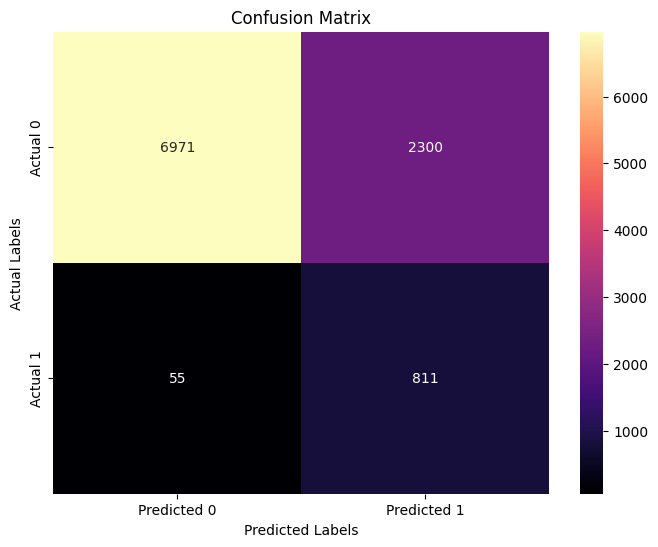

In [23]:
y_pred = model.predict(X_test)

threshold = 0.5
y_pred = (y_pred > threshold).astype(int)

roc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("ROC AUC score:", np.mean(roc))
print("Precision:", np.mean(precision))
print("Recall:", np.mean(recall))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

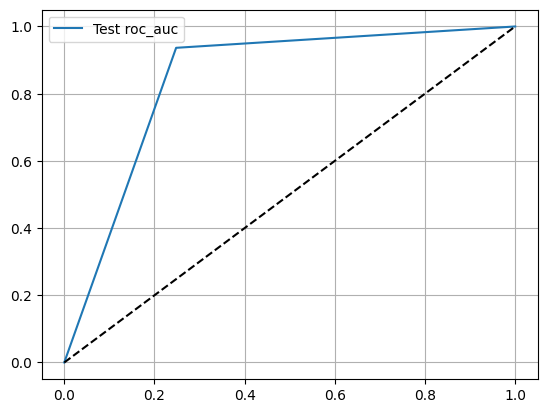

In [24]:
plt.plot(*roc_curve(y_test, y_pred)[:2], label='Test roc_auc')
plt.plot([0,1], [0,1], '--', color='black')
plt.grid()
plt.legend()

##### Что можно сказать, маленький recall, и у нас roc не оченьский, надо делать feature engineering чтобы модель получала больше информации, но у нас в большей части категориальные данные, так что только на human sense надо создавать фичи, устанавливать порог, тюнить модель или посмотреть еще раз на данные